In [ ]:
from typing_extensions import TypedDict
from typing import Dict, List,Any
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.messages import HumanMessage,SystemMessage,AIMessage,AnyMessage
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display
import json
import os
import re
from dotenv import load_dotenv
load_dotenv()
# tools
from Tools.Doc_QnA_RAG import rag_qa_tool
from Tools.News import financial_news_search
from Tools.general_qna import gen_qna
from Tools.Image_qna import image_qna


2025-07-16 19:35:37,330 - unstract.llmwhisperer.client_v2 - DEBUG - logging_level set to DEBUG
2025-07-16 19:35:37,332 - unstract.llmwhisperer.client_v2 - DEBUG - base_url set to https://llmwhisperer-api.us-central.unstract.com/api/v2


In [2]:
class GraphState(TypedDict, total=False):
    input: str
    uploaded_doc : str
    uploaded_img : str
    agent_order: List[Dict[str,str]]
    routing_reasoning : str      
    current_agent_index : int
    processed_agents : List[str]        
    agent_outputs: Dict[str, str]       
    final_response: str  
    messages: List[AnyMessage]  

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0, google_api_key=os.getenv("GOOGLE_API_KEY"))


In [8]:
# llm = ChatGroq(
#     model_name="llama-3.3-70b-versatile",
#     temperature=0.0,
# )

# llm = ChatGroq(
#     model_name="gemma2-9b-it",
#     temperature=0.0,
# )
from langchain_ollama import ChatOllama

# Initialize the Llama 3.1 8B model with the custom endpoint
llm = ChatOllama(
    model="llama3.1:8b",
    base_url="https://ollama-gcs-172789587838.us-central1.run.app",
    temperature=0.7
)
llm.invoke("hey")

AIMessage(content="Hey! How's it going? Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'model': 'llama3.1:8b', 'created_at': '2025-07-16T14:09:37.040251052Z', 'done': True, 'done_reason': 'stop', 'total_duration': 828364768, 'load_duration': 282891205, 'prompt_eval_count': 11, 'prompt_eval_duration': 2000000, 'eval_count': 23, 'eval_duration': 542000000, 'model_name': 'llama3.1:8b'}, id='run--c48f6380-9e5d-4ee1-a890-b8cebf9865a0-0', usage_metadata={'input_tokens': 11, 'output_tokens': 23, 'total_tokens': 34})

In [9]:
query = "Tell me a short story"
for chunk in llm.stream(query):
    print(chunk.content, end="", flush=True)

Here's a short story:

**The Little Street Lamp**

In a small village nestled between two great mountains, there stood a tiny street lamp. It was a humble thing, with a rusty metal body and a single, flickering bulb that cast a warm glow over the cobblestone streets.

For as long as anyone could remember, the lamp had been tended by an old woman named Sophia. She would lovingly polish its surface each evening, making sure it shone brightly to light the way for the villagers as they made their way home from work.

One fateful night, a great storm rolled in over the village. The winds howled and the rain lashed down, threatening to extinguish the little lamp's flame. But Sophia was not about to let that happen. She battled against the elements, her hands raw and cold as she kept the lamp alight.

Just when it seemed like all hope was lost, a young traveler stumbled into the village. Drenched and shivering, he sought shelter from the storm beneath the little street lamp's warm glow. As he

In [17]:
ROUTER_PROMPT = """
You are a routing assistant that decomposes user queries into agent-specific sub-queries for a finance chatbot, using the query, conversation history, and available tools to determine execution order, dependencies, and whether the query is a follow-up.
ONLY GIVE THE OUTPUT NOTHING ELSE 
Available Tools:
1. Document_qna: Answers questions about uploaded documents (e.g., PDFs) using RAG. Requires a document ID from uploaded_docs.
2. News: Fetches and analyzes recent financial news or events.
3. Image_qna: Analyzes uploaded images (e.g., charts, tables).
4. General_qna: Handles general finance or reasoning questions without documents or images.
5. Summarizer: Synthesizes or summarizes prior tool outputs or responses, used for follow-ups (e.g., 'make it shorter').

Inputs:
- Query: The current user query.
- Conversation history: JSON list of messages [{type: 'human'/'ai', content: str}].
- Uploaded documents: JSON list of [path: str].
- Uploaded image: Single path string or empty.

Your Task:
1. Analyze the query and history to identify intent, follow-ups, and referenced documents/images.
2. Select the correct document/image from uploaded_docs or uploaded_img using doc_id or history context (e.g., 'document from earlier'). Default to the latest uploaded_docs/image if ambiguous.
3. Decompose the query into sub-queries for relevant tools, ensuring each is clear and isolated.
4. Specify execution order and dependencies (e.g., Document_qna may depend on News).
5. For follow-ups (e.g., 'make it shorter', 'more details'), route to Summarizer with instructions to use history.
6. For ambiguous queries not requiring tools, route to Summarizer to leverage history.
7. Include 'doc_id' for Document_qna and 'img_id' for Image_qna in agent entries.


Output Format:
{
    "agents": [
        {
            "name": "Document_qna",
            "query": "Specific query for document",
            "dependencies": []
        },
        {
            "name": "News",
            "query": "Specific query for news",
            "dependencies": []
        },
        {
            "name": "General_qna",
            "query": "Specific query for reasoning",
            "dependencies": ["Document_qna", "News"]
        },
        {
            "name": "Image_qna",
            "query": "Specific query for image",
            "dependencies": []
        },
        {
            "name": "Summarizer",
            "query": "Synthesize or summarize outputs",
            "dependencies": ["Document_qna", "News"]
        }
    ],
    "reasoning": "Explain decomposition, document/image selection, and dependency logic"
}

Rules:
- If no document/image is referenced and the query is ambiguous, route to Summarizer or General_qna.
- If no tools are suitable (e.g., non-finance query), return an empty agents list.
- For follow-ups, use history to identify prior outputs or context.
- Ensure dependencies reflect logical order (e.g., News before Document_qna for policy impact).

Examples:
1. Query: "What is the revenue in the document uploaded earlier?"
   History: [{"type": "ai", "content": "Uploaded document: /doc1.pdf with ID doc1", "timestamp": "2025-07-16T10:00:00"}]
   Uploaded_docs: [{"id": "doc1", "path": "/doc1.pdf", "timestamp": "2025-07-16T10:00:00"}]
   Output: {
       "agents": [
           {
               "name": "Document_qna",
               "query": "What is the revenue according to the document?",
               "dependencies": []
           }
       ],
       "reasoning": "Query refers to 'document uploaded earlier', matched to doc1 in history."
   }

2. Query: "How does the latest tax policy affect revenue in the new document?"
   History: [{"type": "ai", "content": "Uploaded document: /doc2.pdf with ID doc2"}]
   Uploaded_docs: [{"id": "doc1", "path": "/doc1.pdf"}, {"id": "doc2", "path": "/doc2.pdf"}]
   Output: {
       "agents": [
           {
               "name": "News",
               "query": "What is the latest tax policy?",
               "dependencies": []
           },
           {
               "name": "Document_qna",
               "query": "How does the latest tax policy affect revenue in the document?",
               "dependencies": ["News"]
           }
       ],
       "reasoning": "Query requires tax policy (News) and revenue impact (Document_qna) using latest document (doc2)."
   }

3. Query: "Make it shorter"
   History: [{"type": "ai", "content": "Final response: Revenue is $4.9T..."}]
   Output: {
       "agents": [
           {
               "name": "Summarizer",
               "query": "Summarize the previous response",
               "dependencies": []
           }
       ],
       "reasoning": "Follow-up query refers to prior response, routed to Summarizer."
   }

4. Query: "What does this chart show?"
   Uploaded_img: "/chart1.jpg"
   Output: {
       "agents": [
           {
               "name": "Image_qna",
               "query": "Describe the content of the chart",
               "dependencies": []
           }
       ],
       "reasoning": "Query targets the uploaded image, routed to Image_qna."
   }

5. Query: "What’s the weather today?"
   Output: {
       "agents": [],
       "reasoning": "Non-finance query, no suitable tools."
   }

6. Query: "What does the old document say about taxes, and how does it relate to recent news?"
   History: [{"type": "ai", "content": "Uploaded document: /doc1.pdf with ID doc1"}, {"type": "ai", "content": "Uploaded document: /doc2.pdf with ID doc2"}]
   Uploaded_docs: [{"id": "doc1", "path": "/doc1.pdf"}, {"id": "doc2", "path": "/doc2.pdf"}]
   Output: {
       "agents": [
           {
               "name": "Document_qna",
               "query": "What does the document say about taxes?",
               "dependencies": []
           },
           {
               "name": "News",
               "query": "What are recent news updates on tax policies?",
               "dependencies": []
           },
           {
               "name": "Summarizer",
               "query": "Relate the document’s tax information to recent news",
               "dependencies": ["Document_qna", "News"]
           }
       ],
       "reasoning": "Query references 'old document' (doc1 from history) for taxes and recent news, with Summarizer to combine outputs."
   }
"""

In [21]:
def Router(state: Dict[str, Any]) -> Dict[str, Any]:
    try:
        query = state["input"]      

        # print("query received") 
        messages = [
            SystemMessage(content=ROUTER_PROMPT),
            HumanMessage(content=f"Query: {query}")
        ]
        # print("query structured")
        
        response = llm.invoke(messages)
        raw = response.content.strip()
        if raw.startswith("```"):
            raw = re.sub(r"^```[a-z]*\n?", "", raw)
            raw = re.sub(r"\n?```$", "", raw)

        # print(response.content)
        # print("response generated")
        parsed = json.loads(raw)
        # parsed = json.loads(response.content)
        # print("response parsed!")
        # print(parsed)
        
        agents = parsed.get("agents", [
            {
            "name": "General_qna",
            "query": f"{query}",
            "dependencies": []
        }
        ])
        reasoning = parsed.get("reasoning", "Default routing")
        
        valid_agents = [agent for agent in agents]
    
        if not valid_agents:
            valid_agents = [
            {
            "name": "General_qna",
            "query": f"{query}",
            "dependencies": []
            }
        ]
        state["agent_order"] = valid_agents
        state["routing_reasoning"] = reasoning
        state["agent_outputs"] = {}
        state["processed_agents"] = []
        state["current_agent_index"] = 0          
        
    except Exception as e:
        print(f"Error in Routing : {e}")
        
    return state

In [22]:
query="what is blockchain? and tell me what the given image is?"
initial_state = {
        "input": query,
        "uploaded_doc" : "/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf",
        "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
        "agent_order": [],
        "routing_reasoning" : "",
        "current_agent_index": 0,
        "processed_agents": [],
        "agent_outputs": {},
        "final_response": ""
    }

In [23]:
import pprint
pprint.pprint(Router(initial_state))

{'agent_order': [{'dependencies': [],
                  'name': 'General_qna',
                  'query': 'What is blockchain?'},
                 {'dependencies': [],
                  'name': 'Image_qna',
                  'query': 'Describe the content of the uploaded image'}],
 'agent_outputs': {},
 'current_agent_index': 0,
 'final_response': '',
 'input': 'what is blockchain? and tell me what the given image is?',
 'processed_agents': [],
 'routing_reasoning': 'Query has no specific document/image reference, so '
                      'routed to General_qna for basic finance knowledge. The '
                      'second part targets the uploaded image.',
 'uploaded_doc': '/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf',
 'uploaded_img': '/home/saikrishnanair/balancesheet.png'}


In [24]:
def route_to_agents(state:Dict[str,Any]) -> str:
    agent_order = state.get("agent_order",[{
            "name": "General_qna",
            "query": f"{state["input"]}",
            "dependencies": []
            }])
    
    if "current_agent_index" not in state:
        state["current_agent_index"] = 0

    current_index = state["current_agent_index"]

    if current_index<len(agent_order):
        agent = agent_order[current_index]["name"]
        print(f"Routing to : {agent}, current index at: {current_index}")
        return agent
    return 'Aggregator'

In [25]:
def Document_qna(state:Dict[str,Any]) -> Dict[str,Any]:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    query += f" based on the following {dep} context: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")      

        # print(query)
        uploaded_doc_path = state["uploaded_doc"]
        # print(uploaded_doc_path)
        result  = rag_qa_tool.invoke({
            "file_path": uploaded_doc_path,
            "query": query
        })
        # print(result)
        state["agent_outputs"]["Doc_QnA"] = result
        state["processed_agents"].append("Document_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0

        state["messages"].append(AIMessage(content=f"Document_qna output: {result}"))
    except Exception as e:
        print(f"Error in Doc_QnA : {e}")
    return state

In [26]:
query="what is the revenue for the year 2024?"
initial_state = {
        "input": query,
        "uploaded_doc" : "/home/saikrishnanair/FGPT/2PageNvidia.pdf",
        "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
        "agent_order": [],
        "routing_reasoning" : "",
        "current_agent_index": 0,
        "processed_agents": [],
        "agent_outputs": {},
        "final_response": "",
        "messages": []
    }

Router(initial_state)
Document_qna(initial_state)

Loading cached FAISS index for file hash 18e5e8c3d87123ab981ad67df8c8cf1c...
Loaded cached vector store successfully.


{'input': 'what is the revenue for the year 2024?',
 'uploaded_doc': '/home/saikrishnanair/FGPT/2PageNvidia.pdf',
 'uploaded_img': '/home/saikrishnanair/balancesheet.png',
 'agent_order': [{'name': 'General_qna',
   'query': 'What is the revenue for 2024?',
   'dependencies': []},
  {'name': 'News',
   'query': 'Recent news on 2024 financial reports or statements?',
   'dependencies': []}],
 'routing_reasoning': 'Query requires general knowledge of finance and recent news to provide accurate revenue information.',
 'current_agent_index': 1,
 'processed_agents': ['Document_QnA'],
 'agent_outputs': {'Doc_QnA': 'The revenue for fiscal year 2024 was $60.922 billion.'},
 'final_response': '',
 'messages': [AIMessage(content='Document_qna output: The revenue for fiscal year 2024 was $60.922 billion.', additional_kwargs={}, response_metadata={})]}

In [27]:
def News(state:Dict[str,Any]) -> Dict[str,Any]:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        print(query)
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    query += f" based on the following {dep} context: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")      


        print("entering news tool")
        result = financial_news_search.invoke({"query" : query})
        state["agent_outputs"]["News"] = result
        state["processed_agents"].append("NEWS")
        if state["current_agent_index"] + 1 < len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        state["messages"].append(AIMessage(content=f"News output: {result}"))
    except Exception as e:
        print(f"Error in News : {e}")
    return state

In [50]:
# query="what is the latest financial news"
# initial_state = {
#         "input": query,
#         "uploaded_doc" : "/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf",
#         "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
#         "agent_order": [],
#         "routing_reasoning" : "",
#         "current_agent_index": 0,
#         "processed_agents": [],
#         "agent_outputs": {},
#         "final_response": "",
#         "messages": []
#     }

# Router(initial_state)
# News(initial_state)

What is the latest financial news?
entering news tool
news tool invoked
Searching financial news for: What is the latest financial news?


{'input': 'what is the latest financial news',
 'uploaded_doc': '/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf',
 'uploaded_img': '/home/saikrishnanair/balancesheet.png',
 'agent_order': [{'name': 'News',
   'query': 'What is the latest financial news?',
   'dependencies': []}],
 'routing_reasoning': 'The user is asking for the latest financial news, which falls under the purview of the News tool.',
 'current_agent_index': 0,
 'processed_agents': ['NEWS'],
 'agent_outputs': {'News': "Here's a concise analysis of the provided finance articles, focusing on key takeaways and removing promotional or irrelevant content:\n\n**Key Trends and Developments in Indian Finance:**\n\n*   **Taxation:**\n    *   Income Tax refunds have increased significantly, with faster processing times.\n    *   GST Council is considering major reforms, including rate adjustments.\n    *   Net direct tax collection saw a slight decrease due to increased refunds.\n    *   Recovery of income-tax dues has doubled.

In [28]:
def General_qna(state:Dict[str,Any]) -> Dict[str,Any]:
    try:
        query = state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    query += f" based on the following {dep} context: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")      

        result = gen_qna.invoke({"question" : query})
        state["agent_outputs"]["General_QnA"] = result
        state["processed_agents"].append("General_QnA")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        state["messages"].append(AIMessage(content=f"General_qna output: {result}"))
    except Exception as e:
        print(f"Error in General_qna : {e}")
    return state

In [51]:
# query="what is simple interest?"
# initial_state = {
#         "input": query,
#         "uploaded_doc" : "/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf",
#         "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
#         "agent_order": [],
#         "routing_reasoning" : "",
#         "current_agent_index": 0,
#         "processed_agents": [],
#         "agent_outputs": {},
#         "final_response": "",
#         "messages" : []
#     }

# Router(initial_state)
# General_qna(initial_state)

{'input': 'what is simple interest?',
 'uploaded_doc': '/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf',
 'uploaded_img': '/home/saikrishnanair/balancesheet.png',
 'agent_order': [{'name': 'General_qna',
   'query': 'What is simple interest?',
   'dependencies': []}],
 'routing_reasoning': 'The question is a general financial question about the definition of simple interest, so it should be routed to the General_qna tool.',
 'current_agent_index': 1,
 'processed_agents': ['General_QnA'],
 'agent_outputs': {'General_QnA': "Simple interest is a straightforward method of calculating the interest charged on a principal amount. It's based only on the original principal and doesn't compound, meaning you don't earn interest on previously earned interest. Here's a detailed breakdown:\n\n**Definition:**\n\nSimple interest is calculated by multiplying the principal amount, the interest rate, and the time period (usually in years).\n\n**Formula:**\n\nThe formula for calculating simple interest 

In [29]:
def Image_qna(state:Dict[str,Any]) -> Dict[str,Any]:
    try:
        query =state["agent_order"][state["current_agent_index"]]["query"]
        dependencies_list = state["agent_order"][state["current_agent_index"]]["dependencies"]

        if dependencies_list:
            for dep in dependencies_list:
                if dep in state["agent_outputs"]:
                    dep_output = state["agent_outputs"][dep]
                    query += f" based on the following {dep} context: {dep_output}"
                else:
                    print(f"Dependency {dep} output not found in agent_outputs")  
    
        # print(query)
        uploaded_img = state["uploaded_img"]
        # print(uploaded_doc_path)
        response = image_qna.invoke({
            "uploaded_file": uploaded_img,
            "query": query
        })
        state["agent_outputs"]["Image_qna"] = response
        state["processed_agents"].append("Image_qna")
        if state["current_agent_index"] + 1 <= len(state["agent_order"]):
            state["current_agent_index"] = state["current_agent_index"] + 1 
        else: 
            state["current_agent_index"] = 0
        state["messages"].append(AIMessage(content=f"Image_qna output: {response}"))

    except Exception as e:
        print(f"Error in Image_qna : {e}")
    return state

In [62]:
# query="what is the image ? ?"
# initial_state = {
#         "input": query,
#         "uploaded_doc" : "/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf",
#         "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
#         "agent_order": [],
#         "routing_reasoning" : "",
#         "current_agent_index": 0,
#         "processed_agents": [],
#         "agent_outputs": {},
#         "final_response": "",
#         "messages" : []
#     }

# Router(initial_state)
# Image_qna(initial_state)

In [30]:
def Aggregator(state:Dict[str,Any]) -> Dict[str,Any]:
    try:
        final_agent_outputs = state["agent_outputs"]
        routing_reasoning = state.get("routing_reasoning", "")
        initial_query = state["input"]

        if not final_agent_outputs:
            state["final_response"] = "No agent outputs to aggregate."
            return state
        
        if len(final_agent_outputs) == 1:
            _,response = next(iter(final_agent_outputs.items()))
            state["final_response"] = response

        else:
            aggregation_prompt = f"""
                        You are an expert output aggregator. Given the initial query , Combine the following responses into a coherent, comprehensive answer , also if needed take into consideration the previous converstation history to answer the initial_query.
                        
                        initial query : {initial_query}
                        Routing reasoning: {routing_reasoning}
                        
                        Responses:
                        {json.dumps(final_agent_outputs, indent=2)}

                        Conversation history: {json.dumps([msg.dict() for msg in state["messages"]], indent=2)}
                        Create a unified response that integrates insights from all the responses and the conversation history if needed, while avoiding redundancy.
            
                        """
            messages = [
                SystemMessage(content="You are an expert at synthesizing information from multiple sources."),
                HumanMessage(content=aggregation_prompt)
            ]
            
            response = llm(messages)
            state["final_response"] = response.content
            state["messages"].append(AIMessage(content=state["final_response"]))
    except Exception as e:
        print(f"Error in Aggregation : {e}")

        
    return state

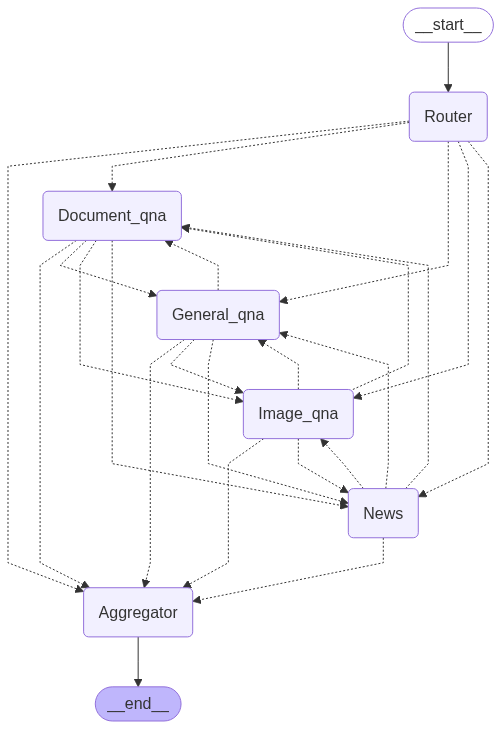

In [31]:
builder = StateGraph(GraphState)

builder.add_node("Router", Router)
builder.add_node("Document_qna", Document_qna)
builder.add_node("General_qna", General_qna)
builder.add_node("News", News)
builder.add_node("Image_qna", Image_qna)

builder.add_node("Aggregator", Aggregator)

builder.set_entry_point("Router")

tool_names = ["Document_qna", "General_qna", "News","Image_qna" ,"Aggregator"]

routing_map = {
    'Document_qna': 'Document_qna',
    'General_qna': 'General_qna',
    'News': 'News',
    "Image_qna" : "Image_qna",
    'Aggregator': 'Aggregator'
}

builder.add_conditional_edges("Router", 
                              route_to_agents,
                                routing_map)


builder.add_conditional_edges("Document_qna", 
    route_to_agents, 
    {
    "General_qna": "General_qna",
    "News": "News",
    "Image_qna" : "Image_qna",
    "Aggregator": "Aggregator"
    }
)

builder.add_conditional_edges("General_qna", 
    route_to_agents, 
    {
    "Document_qna": "Document_qna",
    "News": "News",
    "Image_qna" : "Image_qna",
    "Aggregator": "Aggregator"
    }
)

builder.add_conditional_edges("News", 
    route_to_agents, 
    {
    "Document_qna": "Document_qna",
    "General_qna": "General_qna",
    "Image_qna" : "Image_qna",
    "Aggregator": "Aggregator"
    }
)
builder.add_conditional_edges("Image_qna", 
    route_to_agents, 
    {
    "Document_qna": "Document_qna",
    "General_qna": "General_qna",
    "News": "News",
    "Aggregator": "Aggregator"
    }
)

builder.add_edge("Aggregator", END)

graph = builder.compile()

from IPython.display import Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [32]:
query="what is blockchain? and tell me what the given image is?"
initial_state = {
        "input": query,
        "uploaded_doc" : "/home/saikrishnanair/Finance-GPT/2PageNvidia.pdf",
        "uploaded_img" : "/home/saikrishnanair/balancesheet.png",
        "agent_order": [],
        "routing_reasoning" : "",
        "current_agent_index": 0,
        "processed_agents": [],
        "agent_outputs": {},
        "final_response": "",
        "messages" : []
    }

result = graph.invoke(initial_state)
import pprint
pprint.pprint(result)

Routing to : General_qna, current index at: 0
Routing to : Image_qna, current index at: 1


/tmp/ipykernel_84337/2667560060.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  Conversation history: {json.dumps([msg.dict() for msg in state["messages"]], indent=2)}
/tmp/ipykernel_84337/2667560060.py:34: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(messages)


{'agent_order': [{'dependencies': [],
                  'name': 'General_qna',
                  'query': 'What is blockchain?'},
                 {'dependencies': [],
                  'name': 'Image_qna',
                  'query': 'Describe the content of the uploaded image'}],
 'agent_outputs': {'General_QnA': "Okay, let's break down what blockchain is "
                                  'in a comprehensive and easy-to-understand '
                                  'way.\n'
                                  '\n'
                                  '**What is Blockchain?**\n'
                                  '\n'
                                  'At its core, a blockchain is a '
                                  '**distributed, immutable, and transparent '
                                  'ledger** that records transactions across '
                                  'many computers. Think of it as a digital '
                                  'record book that is shared among many 